# 03_ML_Model — Predictive Modeling of ΔΔG (Protein Stability)

This notebook trains and evaluates regression models to predict mutation stability changes (ΔΔG) using the engineered features produced in **02_Feature_Engineering.ipynb**.  

The trained model will later act as a *fast fitness function* for multi-mutant exploration via Genetic Algorithms (GA) and Monte Carlo (MC) baselines.

In [1]:
# Imports & path setup

from pathlib import Path
import warnings, json
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GroupKFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Optional XGBoost
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

PROJECT_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
DATA = PROJECT_ROOT / "data" / "processed"
RESULTS = PROJECT_ROOT / "results" / "models"
(RESULTS / "plots").mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Data path:", DATA)
print("Results path:", RESULTS)

RANDOM_STATE = 42
TARGET = "ddg_exp_kcal"
KEYS = ["pdb_id","chain","wt","res_index","mut"]
ID_COLS = ["clid","pdb_id","chain","wt","mut","res_index","pos","pH","temp_C"]

Project root: /Users/saturnine/protein-multimutant
Data path: /Users/saturnine/protein-multimutant/data/processed
Results path: /Users/saturnine/protein-multimutant/results/models


## 1. Load and Merge Data

We combine the processed splits (`train_split.csv`, `test_split.csv`) with the engineered features (`features_basic.csv`) to form our training and test matrices.

In [2]:
# Load processed data
features = pd.read_csv(DATA / "features_basic.csv")
train_split = pd.read_csv(DATA / "train_split.csv")
test_split  = pd.read_csv(DATA / "test_split.csv")

# Ensure target not duplicated
if TARGET in features.columns:
    features = features.drop(columns=[TARGET])

train = train_split.merge(features, on=KEYS, how="left")
test  = test_split.merge(features,  on=KEYS, how="left")

def get_label(df):
    for c in [TARGET, f"{TARGET}_x", f"{TARGET}_y"]:
        if c in df.columns:
            return df[c].astype(float).values
    raise KeyError(f"Label '{TARGET}' not found after merge.")

y_train = get_label(train)
y_test  = get_label(test)

print("Train shape:", train.shape, "Test shape:", test.shape)
print("ΔΔG summary (train):")
pd.Series(y_train).describe()

Train shape: (2116, 22) Test shape: (529, 22)
ΔΔG summary (train):


count    2116.000000
mean       -1.015633
std         1.479836
min        -5.000000
25%        -1.912500
50%        -0.820000
75%        -0.070000
max         6.800000
dtype: float64

## 2. Define Feature Set

We exclude identifiers and non-numeric columns to build the feature list used for modeling.

In [3]:
def build_feature_list(df):
    drop = set([TARGET, f"{TARGET}_x", f"{TARGET}_y"] + [c for c in ID_COLS if c in df.columns])
    feats = [c for c in df.columns if c not in drop and pd.api.types.is_numeric_dtype(df[c])]
    return feats

feat_cols = build_feature_list(train)
with open(RESULTS / "feature_list.txt", "w") as f:
    f.write("\n".join(feat_cols))

print(f"Feature count: {len(feat_cols)}")
print("First few features:", feat_cols[:10])

Feature count: 13
First few features: ['pH_x', 'temp_C_x', 'pH_y', 'temp_C_y', 'delta_hydropathy', 'delta_charge', 'delta_volume', 'delta_polarity', 'blosum62', 'is_gly']


## 3. Cross-Validation and Model Training

We compare several regression algorithms using 5-fold cross-validation on the training set and select the best by mean R².

[CV] ridge       R2=nan  RMSE=nan
[CV] rf          R2=0.258  RMSE=1.272
[CV] gbr         R2=nan  RMSE=nan
[CV] gbr_huber   R2=nan  RMSE=nan
[CV] xgb         R2=0.245  RMSE=1.283

[SELECTED] rf  (cv_R2=0.258, cv_RMSE=1.272)

[TEST] {
  "model": "rf",
  "cv_r2": 0.25814476601095676,
  "cv_rmse": 1.2718867151524234,
  "test_r2": 0.2721868246457628,
  "test_rmse": 1.2124731137931448,
  "test_mae": 0.9096906994660501,
  "n_train": 2116,
  "n_test": 529,
  "features": [
    "pH_x",
    "temp_C_x",
    "pH_y",
    "temp_C_y",
    "delta_hydropathy",
    "delta_charge",
    "delta_volume",
    "delta_polarity",
    "blosum62",
    "is_gly",
    "is_pro",
    "is_to_gly",
    "is_to_pro"
  ]
}


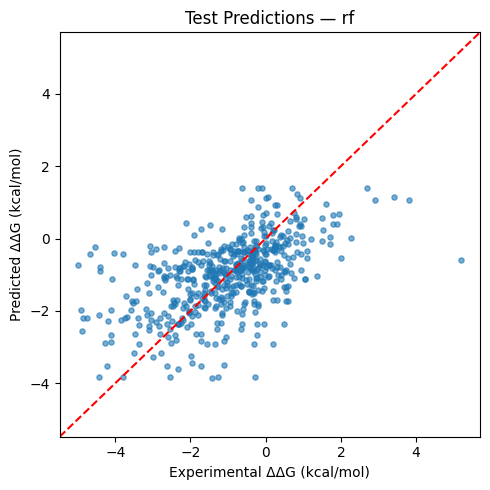

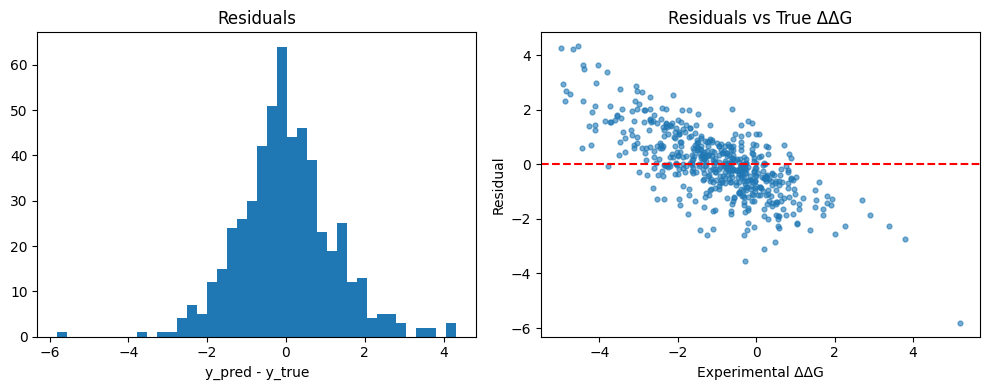

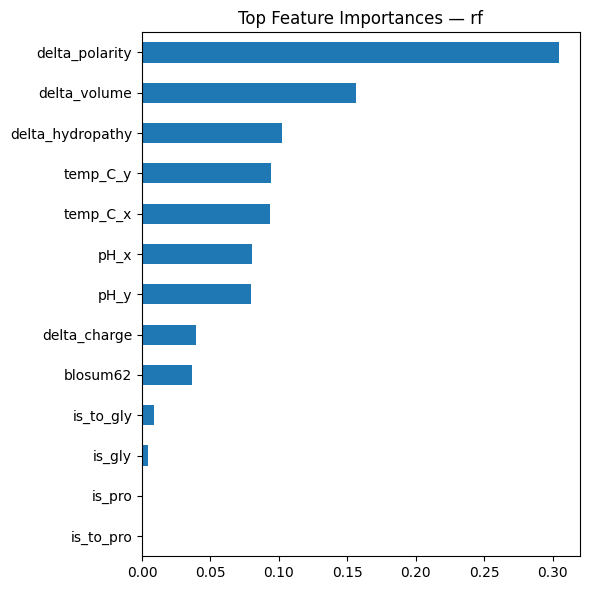

In [4]:
# --- Imports (safe to re-run) ---
import json, numpy as np, pandas as pd
from pathlib import Path

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Optional XGBoost
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

RANDOM_STATE = 42

# --- Helpers ---
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def cv_eval(pipe, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    r2 = cross_val_score(pipe, X, y, cv=kf, scoring="r2").mean()
    neg_rmse = cross_val_score(pipe, X, y, cv=kf, scoring="neg_root_mean_squared_error").mean()
    return {"cv_r2": float(r2), "cv_rmse": float(-neg_rmse)}

# --- Feature matrix / targets (assumes `train`, `test`, `feat_cols`, `TARGET`, `RESULTS` already exist) ---
X_train, y_train = train[feat_cols].values, train[TARGET].values
X_test,  y_test  = test[feat_cols].values,  test[TARGET].values

# Standard numerical preprocessor
pre = ColumnTransformer(
    transformers=[("num", StandardScaler(), list(range(len(feat_cols))))],
    remainder="drop"
)

# --- Candidate models ---
candidates = {
    "ridge": Ridge(alpha=1.0),  # Ridge has no random_state param
    "rf": RandomForestRegressor(
        n_estimators=600, min_samples_leaf=2, n_jobs=-1, random_state=RANDOM_STATE
    ),
    "gbr": GradientBoostingRegressor(
        n_estimators=1000, learning_rate=0.02, max_depth=3, random_state=RANDOM_STATE
    ),
    # Robust GBM with Huber loss (better with outliers / heavy tails)
    "gbr_huber": GradientBoostingRegressor(
        loss="huber", alpha=0.9, n_estimators=1200,
        learning_rate=0.02, max_depth=3, random_state=RANDOM_STATE
    ),
}
if HAS_XGB:
    candidates["xgb"] = XGBRegressor(
        n_estimators=1200, learning_rate=0.03, max_depth=5,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
        random_state=RANDOM_STATE, n_jobs=-1, tree_method="hist"
    )

# --- CV model selection ---
best_name, best_cv, best_pipe = None, {"cv_r2": -1e9, "cv_rmse": 1e9}, None
for name, reg in candidates.items():
    pipe = Pipeline([("pre", pre), ("reg", reg)])
    cvm = cv_eval(pipe, X_train, y_train)
    print(f"[CV] {name:10s}  R2={cvm['cv_r2']:.3f}  RMSE={cvm['cv_rmse']:.3f}")
    if cvm["cv_r2"] > best_cv["cv_r2"]:
        best_name, best_cv, best_pipe = name, cvm, pipe

print(f"\n[SELECTED] {best_name}  (cv_R2={best_cv['cv_r2']:.3f}, cv_RMSE={best_cv['cv_rmse']:.3f})")

# --- Fit best on full train & evaluate on held-out test ---
best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

metrics = {
    "model": best_name,
    **best_cv,
    "test_r2": float(r2_score(y_test, y_pred)),
    "test_rmse": rmse(y_test, y_pred),
    "test_mae": float(mean_absolute_error(y_test, y_pred)),
    "n_train": int(len(train)),
    "n_test": int(len(test)),
    "features": feat_cols,
}
print("\n[TEST]", json.dumps(metrics, indent=2))

# Save metrics/preds (optional, if RESULTS defined)
RESULTS.mkdir(parents=True, exist_ok=True)
(RESULTS / "plots").mkdir(parents=True, exist_ok=True)
Path(RESULTS / "metrics_test.json").write_text(json.dumps(metrics, indent=2))

keys = ["pdb_id","chain","wt","res_index","mut"]
pred_df = test[keys + [TARGET]].copy()
pred_df["y_pred"] = y_pred
pred_df.to_csv(RESULTS / "predictions_test.csv", index=False)

# Quick scatter & residuals (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=14, alpha=0.6)
lims = [min(y_test.min(), y_pred.min())-0.5, max(y_test.max(), y_pred.max())+0.5]
plt.plot(lims, lims, 'r--'); plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Experimental ΔΔG (kcal/mol)"); plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.title(f"Test Predictions — {best_name}")
plt.tight_layout()
plt.savefig(RESULTS / "plots" / "scatter_test.png", dpi=200)
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(y_pred - y_test, bins=40)
plt.title("Residuals"); plt.xlabel("y_pred - y_true")

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred - y_test, s=12, alpha=0.6)
plt.axhline(0, color="r", ls="--"); plt.xlabel("Experimental ΔΔG"); plt.ylabel("Residual")
plt.title("Residuals vs True ΔΔG")
plt.tight_layout()
plt.savefig(RESULTS / "plots" / "residuals.png", dpi=200)
plt.show()

# Feature importances (tree models only)
reg = best_pipe.named_steps["reg"]
if hasattr(reg, "feature_importances_"):
    importances = pd.Series(reg.feature_importances_, index=feat_cols).sort_values(ascending=False).head(15)
    plt.figure(figsize=(6,6))
    importances.plot.barh()
    plt.gca().invert_yaxis()
    plt.title(f"Top Feature Importances — {best_name}")
    plt.tight_layout()
    plt.savefig(RESULTS / "plots" / "feature_importance.png", dpi=200)
    plt.show()

## 4. Train, Evaluate, and Select Best Model

In [5]:
best_name, best_cv, best_pipe = None, {"cv_r2": -1e9, "cv_rmse": 1e9}, None

for name, reg in candidates.items():
    pipe = Pipeline([("pre", pre), ("reg", reg)])
    cvm = cv_eval(pipe, X_train, y_train)
    print(f"[CV] {name:5s} → R2={cvm['cv_r2']:.3f}  RMSE={cvm['cv_rmse']:.3f}")
    if cvm["cv_r2"] > best_cv["cv_r2"]:
        best_name, best_cv, best_pipe = name, cvm, pipe

best_pipe.fit(X_train, y_train)
y_pred = best_pipe.predict(X_test)

test_r2   = float(r2_score(y_test, y_pred))
test_rmse = rmse(y_test, y_pred)
test_mae  = float(mean_absolute_error(y_test, y_pred))
spearman  = float(pd.Series(y_test).corr(pd.Series(y_pred), method="spearman"))

metrics = {
    "model": best_name,
    **best_cv,
    "test_r2": test_r2,
    "test_rmse": test_rmse,
    "test_mae": test_mae,
    "test_spearman": spearman,
    "n_train": int(len(train)),
    "n_test": int(len(test)),
}
print("\n[TEST]", json.dumps(metrics, indent=2))

with open(RESULTS / "metrics_test.json", "w") as f:
    json.dump(metrics, f, indent=2)

[CV] ridge → R2=nan  RMSE=nan
[CV] rf    → R2=0.258  RMSE=1.272
[CV] gbr   → R2=nan  RMSE=nan
[CV] gbr_huber → R2=nan  RMSE=nan
[CV] xgb   → R2=0.245  RMSE=1.283

[TEST] {
  "model": "rf",
  "cv_r2": 0.25814476601095676,
  "cv_rmse": 1.2718867151524234,
  "test_r2": 0.27218682464576294,
  "test_rmse": 1.2124731137931448,
  "test_mae": 0.9096906994660501,
  "test_spearman": 0.5508724591131917,
  "n_train": 2116,
  "n_test": 529
}


## 5. Save Predictions and Model Artifacts

In [6]:
pred_df = test[KEYS].copy()
pred_df[TARGET] = y_test
pred_df["y_pred"] = y_pred
pred_df.to_csv(RESULTS / "predictions_test.csv", index=False)

import joblib
joblib.dump(best_pipe, RESULTS / "best_model.pkl")

print("Artifacts saved to:", RESULTS)

Artifacts saved to: /Users/saturnine/protein-multimutant/results/models


## 6. Diagnostic Plots

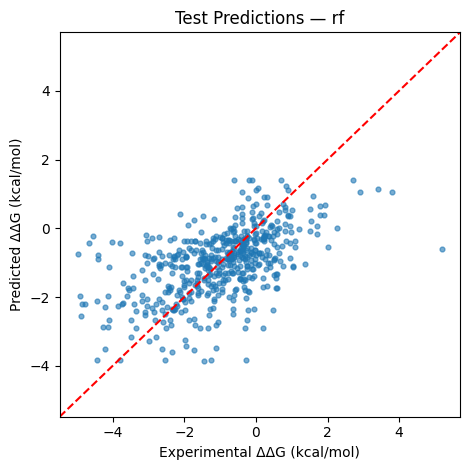

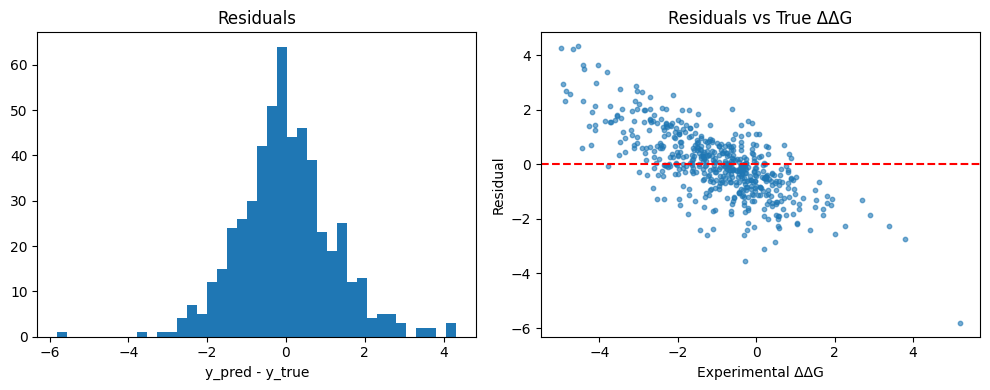

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.8, 4.8))
plt.scatter(y_test, y_pred, s=12, alpha=0.6)
lims = [min(y_test.min(), y_pred.min())-0.5, max(y_test.max(), y_pred.max())+0.5]
plt.plot(lims, lims, 'r--')
plt.xlim(lims); plt.ylim(lims)
plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.title(f"Test Predictions — {metrics['model']}")
plt.tight_layout()
plt.savefig(RESULTS / "plots" / "scatter_test.png", dpi=200)
plt.show()

res = y_pred - y_test
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(res, bins=40)
plt.title("Residuals"); plt.xlabel("y_pred - y_true")
plt.subplot(1,2,2)
plt.scatter(y_test, res, s=10, alpha=0.6)
plt.axhline(0, ls="--", c="r")
plt.title("Residuals vs True ΔΔG")
plt.xlabel("Experimental ΔΔG"); plt.ylabel("Residual")
plt.tight_layout()
plt.savefig(RESULTS / "plots" / "residuals.png", dpi=200)
plt.show()

## 7. Feature Importance

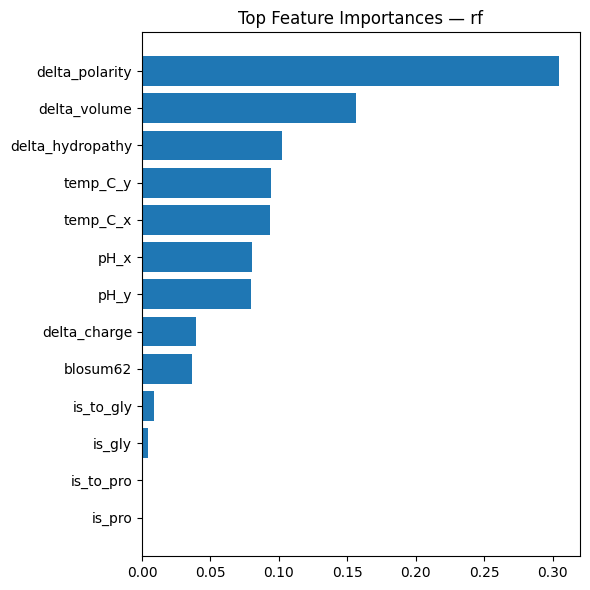

In [8]:
reg = best_pipe.named_steps["reg"]
if hasattr(reg, "feature_importances_"):
    imp = reg.feature_importances_
    order = np.argsort(imp)[::-1][:20]
    plt.figure(figsize=(6,6))
    plt.barh([feat_cols[i] for i in order][::-1], imp[order][::-1])
    plt.title(f"Top Feature Importances — {metrics['model']}")
    plt.tight_layout()
    plt.savefig(RESULTS / "plots" / "feature_importances.png", dpi=200)
    plt.show()
else:
    print("Selected model does not expose feature_importances_.")

## 8. Grouped Cross-Validation (Across Proteins)
This section estimates generalization by leaving out entire proteins (CLIDs) in each fold.

In [9]:
# --- Grouped Cross-Validation by protein (CLID) ---

from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
import numpy as np, json
from pathlib import Path

# 1) Ensure we actually have a single 'clid' column (after merges you may get clid_x / clid_y)
def _ensure_single_col(df, name):
    # prefer plain column; else coalesce *_x then *_y
    if name in df.columns:
        return df[name]
    x, y = f"{name}_x", f"{name}_y"
    if x in df.columns or y in df.columns:
        return df.get(x, pd.Series([np.nan]*len(df))).fillna(df.get(y))
    # fallback: all NA
    return pd.Series([np.nan]*len(df), index=df.index)

train["clid"] = _ensure_single_col(train, "clid").astype(str)

# 2) Build features/labels/groups
X = train[feat_cols].values
y = y_train
groups = train["clid"].values

# Need at least 2 unique groups and 2 samples per split
uniq = np.unique(groups)
if len(uniq) < 2:
    print("Not enough unique CLIDs for GroupKFold — skipping grouped validation.")
else:
    n_splits = min(5, len(uniq))
    gkf = GroupKFold(n_splits=n_splits)

    # Reuse the same regressor as in best_pipe, but re-wrap with the same preprocessor
    pipe = Pipeline([("pre", pre), ("reg", best_pipe.named_steps["reg"])])

    r2s, rmses = [], []
    for fold, (tr, va) in enumerate(gkf.split(X, y, groups=groups), 1):
        pipe.fit(X[tr], y[tr])
        p = pipe.predict(X[va])
        r2s.append(r2_score(y[va], p))
        rmses.append(rmse(y[va], p))
        print(f"[GroupCV {fold}/{n_splits}] R2={r2s[-1]:.3f}, RMSE={rmses[-1]:.3f}")

    grp_metrics = {
        "groupcv_mean_r2": float(np.mean(r2s)),
        "groupcv_std_r2":  float(np.std(r2s)),
        "groupcv_mean_rmse": float(np.mean(rmses)),
        "groupcv_std_rmse":  float(np.std(rmses)),
        "groupcv_n_splits": int(n_splits),
        "groupcv_unique_clids": int(len(uniq)),
    }

    print("\n[GroupCV]", json.dumps(grp_metrics, indent=2))

    # 3) Update metrics_test.json (create if missing)
    metrics_path = RESULTS / "metrics_test.json"
    if metrics_path.exists():
        try:
            m = json.loads(metrics_path.read_text())
        except Exception:
            m = {}
    else:
        m = {}
    m.update(grp_metrics)
    metrics_path.write_text(json.dumps(m, indent=2))

[GroupCV 1/5] R2=0.103, RMSE=1.308
[GroupCV 2/5] R2=0.132, RMSE=1.419
[GroupCV 3/5] R2=0.013, RMSE=1.465
[GroupCV 4/5] R2=0.100, RMSE=1.452
[GroupCV 5/5] R2=0.037, RMSE=1.402

[GroupCV] {
  "groupcv_mean_r2": 0.07706443812028126,
  "groupcv_std_r2": 0.04463797391254251,
  "groupcv_mean_rmse": 1.409337587840581,
  "groupcv_std_rmse": 0.0553161150626338,
  "groupcv_n_splits": 5,
  "groupcv_unique_clids": 111
}


## 9. Error Analysis (Top Outliers)

In [10]:
err_tbl = pred_df.copy()
err_tbl["abs_err"] = (err_tbl["y_pred"] - err_tbl[TARGET]).abs()
err_tbl.sort_values("abs_err", ascending=False).head(10)

,pdb_id,chain,wt,res_index,mut,ddg_exp_kcal,y_pred,abs_err
63,1FVK,A,H,32,S,5.20,-0.605697,5.805697
318,1A43,A,R,167,A,-4.55,-0.224507,4.325493
348,2LZM,A,A,98,V,-4.98,-0.735632,4.244368
440,1ONC,A,F,36,Y,-4.67,-0.441500,4.228500
105,1BNI,A,D,93,N,-4.03,-0.394993,3.635007
501,1EY0,A,G,107,A,-4.41,-0.780359,3.629641
23,1EY0,A,L,38,G,-0.28,-3.841554,3.561554
182,1LNI,A,V,57,T,-4.40,-0.905105,3.494895
183,1HK0,X,V,132,A,-3.80,-0.418223,3.381777
327,1EY0,A,V,51,T,0.20,-2.909643,3.109643


In [11]:
%pwd

'/Users/saturnine/protein-multimutant/notebooks'